In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
from keras.applications import DenseNet121
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import seaborn as sns
import os
import h5py

In [8]:
# Define dataset root path
dataset_root = r'R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake'  # Fixed double backslashes
train_dir = os.path.join(dataset_root, 'train')
test_dir = os.path.join(dataset_root, 'test')
val_dir = os.path.join(dataset_root, 'valid')

# Create data generators
data_gen = ImageDataGenerator(rescale=1./255)
train_generator = data_gen.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32, class_mode='binary')
test_generator = data_gen.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32, class_mode='binary', shuffle=False)
val_generator = data_gen.flow_from_directory(val_dir, target_size=(64, 64), batch_size=32, class_mode='binary')


Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [9]:
# Load DenseNet121 without pre-trained weights
base_model = DenseNet121(include_top=False, weights=None, input_shape=(64, 64, 3))

In [20]:
# Fix HDF5 weight file issue
weights_path = r"R:\densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"

with h5py.File(weights_path, "r+") as f:
    if "keras_version" in f.attrs:
        del f.attrs["keras_version"]  # Delete keras_version
    if "backend" in f.attrs:
        del f.attrs["backend"]  # Delete backend info if needed

In [21]:
# Load weights after fixing
base_model.load_weights(weights_path)


In [22]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False


In [23]:
# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification
model = Model(inputs=base_model.input, outputs=x)

# Model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [25]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit_generator(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20


INFO:plaidml:Analyzing Ops: 1030 of 2872 operations complete
INFO:plaidml:Analyzing Ops: 2819 of 2872 operations complete


3173/3189 [============================>.] - ETA: 2s - loss: 0.5791 - acc: 0.6962      

INFO:plaidml:Analyzing Ops: 1773 of 2872 operations complete


3189/3189 [==============================] - 592s 186ms/step - loss: 0.5790 - acc: 0.6963 - val_loss: 1.8909 - val_acc: 0.5018
Epoch 2/20
3189/3189 [==============================] - 461s 144ms/step - loss: 0.5417 - acc: 0.7252 - val_loss: 2.5471 - val_acc: 0.5079
Epoch 3/20
3189/3189 [==============================] - 470s 147ms/step - loss: 0.5256 - acc: 0.7372 - val_loss: 1.8980 - val_acc: 0.5113
Epoch 4/20
3189/3189 [==============================] - 462s 145ms/step - loss: 0.5137 - acc: 0.7465 - val_loss: 2.7526 - val_acc: 0.5058
Epoch 5/20
3189/3189 [==============================] - 458s 144ms/step - loss: 0.5056 - acc: 0.7529 - val_loss: 2.3165 - val_acc: 0.5151
Epoch 6/20
3189/3189 [==============================] - 465s 146ms/step - loss: 0.4985 - acc: 0.7571 - val_loss: 1.8133 - val_acc: 0.5173
Epoch 7/20
3189/3189 [==============================] - 455s 143ms/step - loss: 0.4918 - acc: 0.7612 - val_loss: 1.7314 - val_acc: 0.5249
Epoch 8/20
3189/3189 [=======================

In [26]:
# Save the model
model.save('densenet.h5')
print("Model saved as densenet.h5")

Model saved as densenet.h5


In [27]:
# Plot loss function
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot accuracy function
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [28]:
# Retrieve training history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


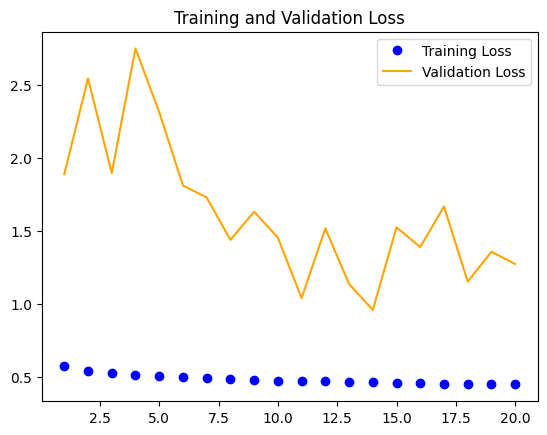

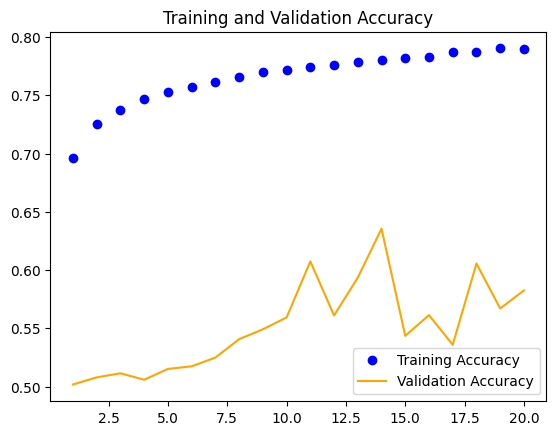

In [29]:
# Plot results
plot_loss(range(1, 21), loss, val_loss)
plot_accuracy(range(1, 21), acc, val_acc)


In [30]:
import numpy as np

# Store predictions and true labels
y_pred_list = []
y_true_list = []

# Iterate over all batches in the test generator
for i in range(len(test_generator)):
    X_batch, y_batch = next(test_generator)  # Get batch images & labels
    y_pred_batch = model.predict(X_batch, verbose=0)  # Predict batch
    y_pred_list.extend(y_pred_batch.flatten())  # Store predictions
    y_true_list.extend(y_batch.flatten())  # Store true labels

# Convert predictions to binary labels (0 = Fake, 1 = Real)
y_pred_classes = (np.array(y_pred_list) > 0.5).astype(int)
y_true_classes = np.array(y_true_list)

# Print predictions and true labels
print("Predicted Labels:", y_pred_classes)
print("Actual Labels:", y_true_classes)

INFO:plaidml:Analyzing Ops: 1437 of 1537 operations complete


Predicted Labels: [0 0 0 ... 0 0 1]
Actual Labels: [0. 0. 0. ... 1. 1. 1.]


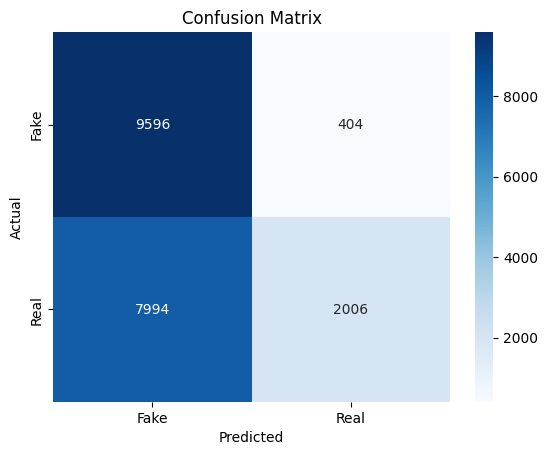

In [31]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Fake', 'Real']))


              precision    recall  f1-score   support

        Fake       0.55      0.96      0.70     10000
        Real       0.83      0.20      0.32     10000

    accuracy                           0.58     20000
   macro avg       0.69      0.58      0.51     20000
weighted avg       0.69      0.58      0.51     20000



In [33]:
# Compute and print additional metrics
print("ROC AUC Score:", roc_auc_score(y_true_classes,y_pred_classes))
print("AP Score:", average_precision_score(y_true_classes, y_pred_classes))

ROC AUC Score: 0.5801000000000001
AP Score: 0.5666724481327801


In [37]:
import cv2
import numpy as np

def predict_image(img_path):
    img = cv2.imread(img_path)

    # ✅ Check if the image was loaded successfully
    if img is None:
        print(f"Error: Unable to load image at {img_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)
    
    prediction = model.predict(img)[0][0]
    pred_label = 'Real' if prediction > 0.5 else 'Fake'
    print(f'The image at {img_path} is predicted as: {pred_label} (Confidence: {prediction:.2f})')
    
    return pred_label

# Example usage
img_path = r"R:\fake photo.jpg" # ✅ Make sure the path is correct
predict_image(img_path)



The image at R:\fake photo.jpg is predicted as: Fake (Confidence: 0.02)


'Fake'

In [40]:
import os

fake_images_folder = r"R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake\test\fake"  # Change this to your Fake dataset path
fake_images = [os.path.join(fake_images_folder, f) for f in os.listdir(fake_images_folder) if f.endswith(('.jpg', '.png'))]

for fake_image in fake_images[:10]:  # Test first 5 fake images
    result = predict_image(fake_image)
    print(f"{fake_image} → {result}")

The image at R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake\test\fake\00276TOPP4.jpg is predicted as: Real (Confidence: 0.59)
R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake\test\fake\00276TOPP4.jpg → Real
The image at R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake\test\fake\008BYSE725.jpg is predicted as: Fake (Confidence: 0.00)
R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake\test\fake\008BYSE725.jpg → Fake
The image at R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake\test\fake\009ZTJ3621.jpg is predicted as: Fake (Confidence: 0.01)
R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake\test\fake\009ZTJ3621.jpg → Fake
The image at R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake\test\fake\00F8LKY6JC.jpg is predicted 